In [1]:
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
import matplotlib.ticker as ticker
import pandas as pd

In [2]:
def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [3]:
gconst = 6.67430e-8
clight = 2.99792458e10
solar = 1.98847e33
lencgs2code = (clight**2)/(solar*gconst)
masscgs2code = (1.0e0/solar)
rhocgs2code = (masscgs2code/lencgs2code**3)
tcgs2code = (clight**3)/(solar*gconst)
energycgs2code = (1.0E0/clight**2)
me2 = 9.1093837015e-28*masscgs2code
mb2 = 1.66053906660e-24*masscgs2code
ye = 0.5e0
h_bar = (1.054571817e-27)*(lencgs2code**2*masscgs2code/tcgs2code)
amax = (me2**4)/(2.4e1*np.pi**2*h_bar**3)
bmax = (mb2*me2**3)/(3.0e0*np.pi**2*h_bar**3*ye)

In [4]:
def xe(rho):
    return (rho/bmax)**(1.0e0/3.0e0)
def dpdx(x):
    return 8.0e0*x**4/np.sqrt(x**2 + 1.0e0)
def cs(rho):
    return np.sqrt(amax*dpdx(xe(rho))/3.0e0/(rho**2*bmax)**(1.0e0/3.0e0))

In [5]:
# Face value
x1f = np.loadtxt('/home/cnchong/Codes/cumc3d/model/Type_Ia/profile/hydro_x1_fgrid.dat').T
x3f = np.loadtxt('/home/cnchong/Codes/cumc3d/model/Type_Ia/profile/hydro_x3_fgrid.dat').T
# Center value
x1f = x1f [3:-3]*lencgs2code # Remove BC
x1c = (x1f[1:]+x1f[:-1])/2 #mid pt
x3f = x3f[3:-3]*lencgs2code # Remove BC
x3c = (x3f[1:]+x3f[:-1])/2 #mid pt

xx,yy= np.meshgrid(x1c,x3c,indexing='ij')

xxf, yyf = np.meshgrid(x1f,x3f,indexing='ij')

In [6]:
# Initial Values
irho = np.loadtxt('/home/cnchong/Codes/cumc3d/model/Type_Ia/profile/hydro_rho.dat').T*rhocgs2code
ieps = np.loadtxt('/home/cnchong/Codes/cumc3d/model/Type_Ia/profile/hydro_eps.dat').T*energycgs2code
ivz = np.loadtxt('/home/cnchong/Codes/cumc3d/model/Type_Ia/profile/hydro_vphi.dat').T
iHe4 = np.loadtxt('/home/cnchong/Codes/cumc3d/model/Type_Ia/profile/Helm_Xhe4.dat').T
iC12 = np.loadtxt('/home/cnchong/Codes/cumc3d/model/Type_Ia/profile/Helm_Xc12.dat').T
iO16 = np.loadtxt('/home/cnchong/Codes/cumc3d/model/Type_Ia/profile/Helm_Xo16.dat').T
iNe20 = np.loadtxt('/home/cnchong/Codes/cumc3d/model/Type_Ia/profile/Helm_Xne20.dat').T
iMg24 = np.loadtxt('/home/cnchong/Codes/cumc3d/model/Type_Ia/profile/Helm_Xmg24.dat').T
iSi28 = np.loadtxt('/home/cnchong/Codes/cumc3d/model/Type_Ia/profile/Helm_Xsi28.dat').T
iNi56 = np.loadtxt('/home/cnchong/Codes/cumc3d/model/Type_Ia/profile/Helm_Xni56.dat').T

In [7]:
# Free fall time compared to simulation time (cgs)
ff_time = np.sqrt((3*np.pi)/(32*gconst*np.average(irho/rhocgs2code)))
print(ff_time)

0.3757734566917955


In [8]:
(27171.14208063890/tcgs2code)/ff_time

0.3561594333328563

In [9]:
filename = "/home/cnchong/Codes/cumc3d/model/Type_Ia/outfile/cylindrical_PPM_HLLC/rkiter-0-nm.hdf5"
f = h5py.File(filename, "r")
f.keys()

<KeysViewHDF5 ['bfield', 'coordinate', 'cs', 'dimension', 'epsilon', 'primitive', 'temp', 'time', 'x-interface', 'y-interface', 'z-interface']>

In [10]:
prim_list = []
n = 87
for i in range(n):
    filename = "/home/cnchong/Codes/cumc3d/model/Type_Ia/outfile/cylindrical_PPM_HLLC/rkiter-"+str(i)+"-nm.hdf5"
    f = h5py.File(filename, "r")
    primitive = f['primitive'][:]
    primitive = primitive.T
    prim_list.append(primitive)
    f.close()
epsilon_list = []
for i in range(n):
    filename = "/home/cnchong/Codes/cumc3d/model/Type_Ia/outfile/cylindrical_PPM_HLLC/rkiter-"+str(i)+"-nm.hdf5"
    f = h5py.File(filename, "r")
    epsilon = f['epsilon'][:]
    epsilon = epsilon.T
    epsilon_list.append(epsilon)
    f.close()
temp_list = []
for i in range(n):
    filename = "/home/cnchong/Codes/cumc3d/model/Type_Ia/outfile/cylindrical_PPM_HLLC/rkiter-"+str(i)+"-nm.hdf5"
    f = h5py.File(filename, "r")
    temp = f['temp'][:]
    temp = temp.T
    temp_list.append(temp)
    f.close()

In [11]:
dx2 = np.diff(xxf[:,0]**2)
dy = np.diff(yyf[0,:])
dxx2,dyy = np.meshgrid(dx2,dy)
vol = dxx2*dyy*np.pi

In [12]:
mass_list = []
turbq_list = []
for prim in prim_list:
    mass = np.sum(prim[0,1:-1,1,1:-1].T*vol)
    mass_list.append(mass)
    mass = np.sum(prim[0,1:-1,1,1:-1].T*vol)
    mass_list.append(mass)
mass_arr = np.array(mass_list)

In [13]:
energy_list = []
for eps in epsilon_list:
    energy = np.sum(eps[1:-1,1,1:-1].T*vol)
    energy_list.append(energy)
energy_arr = np.array(energy_list)

Text(0.5, 1.0, 'Mass against time')

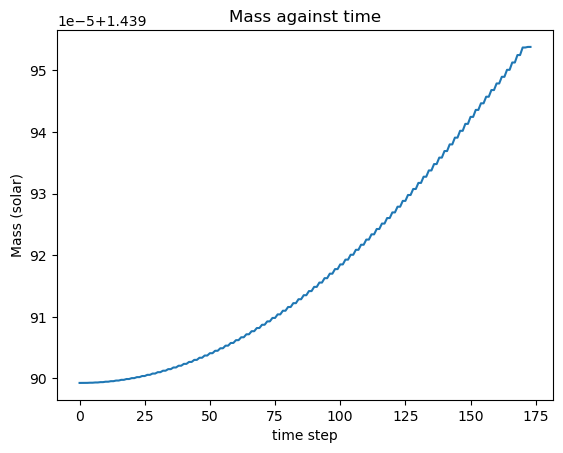

In [14]:
plt.plot(mass_arr)
plt.xlabel('time step')
plt.ylabel('Mass (solar)')
plt.title('Mass against time')

Text(0.5, 1.0, 'Energy against time')

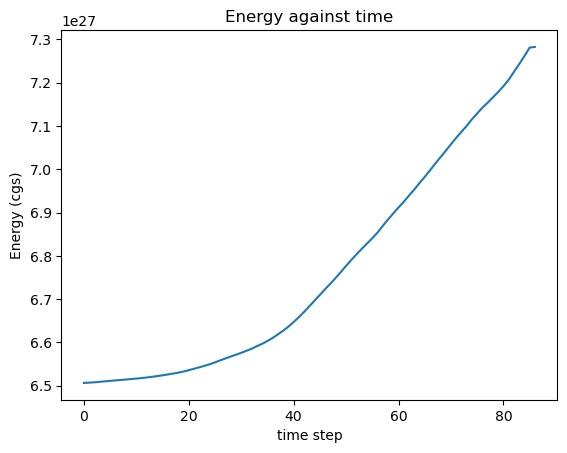

In [15]:
plt.plot(energy_arr/energycgs2code)
plt.xlabel('time step')
plt.ylabel('Energy (cgs)')
plt.title('Energy against time')

In [16]:
def easy_animation(xxf,yyf,data_list, name, ani_name):
    data_list_arr = np.array(data_list)
    fig = plt.figure()
    camera = Camera(fig)
    ax = plt.axes()
    vmin = np.min(data_list_arr)
    vmax = np.max(data_list_arr)
    print(vmin)
    print(vmax)
    for i in range(len(data_list)):
        prim = data_list[i]
        quan = prim
        plt.pcolormesh(xxf,yyf,quan,vmin=vmin,vmax=vmax)
        ax.text(0.3, 1.01, str(name)+ ' at time step ' +str(i), transform=ax.transAxes)
        camera.snap()
    plt.colorbar(format=ticker.FuncFormatter(fmt))
    plt.annotate('max = '+np.format_float_scientific(vmax, precision=3, exp_digits=1), xy=(0.05, 0.95), xycoords='axes fraction', color = 'red')
    plt.annotate('min = '+np.format_float_scientific(vmin, precision=3, exp_digits=1), xy=(0.05, 0.9), xycoords='axes fraction', color = 'red')
    ani = camera.animate()
    ani.save('/home/cnchong/Codes/cumc3d/model/Type_Ia/outfile/cylindrical_PPM_HLLC/'+str(ani_name)+'.mp4')
    plt.close()
    

In [17]:
tau_list = []
for i in range(len(prim_list)):
    tau_list.append(prim_list[i][4,1:-1,1,1:-1])
easy_animation(xxf,yyf,np.array(tau_list), 'tau', 'tau')

5.562536459431042e-22
1.9962547813028533e-11


In [18]:
vz_list = []
for i in range(len(prim_list)):
    vz_list.append(prim_list[i][3,1:-1,1,1:-1])
easy_animation(xxf,yyf,np.array(vz_list), 'vz', 'vz')

-0.03578993742446411
0.03578993737913701


In [19]:
vx_list = []
for i in range(len(prim_list)):
    vx_list.append(prim_list[i][1,1:-1,1,1:-1])
easy_animation(xxf,yyf,np.array(vx_list), 'vx', 'vx')

-0.034190850346593006
0.005455038567441748


In [20]:
dens_list = []
for i in range(len(prim_list)):
    dens_list.append(prim_list[i][0,1:-1,1,1:-1])
easy_animation(xxf,yyf,np.log(np.array(dens_list)), 'log_rho', 'log_rho')

-34.05680964249514
-17.893210660889576


In [21]:
eps_anilist = []
for i in range(len(epsilon_list)):
    eps_anilist.append(epsilon_list[i][1:-1,1, 1:-1])
easy_animation(xxf,yyf,np.log(np.array(eps_anilist)), 'log_eps', 'log_eps')

-14.655978799046125
-5.7196409896827145
